In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# initialize Parameters
learning_rate = 0.0002
size_of_batch = 64
num_epochs = 10
critic_iter = 5
noise_dim = 100
output_folder="./WGANOutput"

In [3]:
# Get CIFAR10 Dataset
data_set = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose([
    transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)

In [4]:
# initializing the weights for generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
# Create Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.main=nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0),
        )
    def forward(self, passedInput):
        return self.main(passedInput).mean(0).view(1)

# Create Generator Class
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, passedInput):
        return self.main(passedInput)

In [6]:
# Create Generator object
discriminator = Discriminator()
# Create Discriminator object
generator = Generator()
#apply initial weights
discriminator.apply(weights_init)
generator.apply(weights_init)
discriminator
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [7]:
# Optimizers
dis_optim = optim.RMSprop(discriminator.parameters(),lr=learning_rate)
gen_optim = optim.RMSprop(generator.parameters(),lr=learning_rate)
criterion = nn.BCELoss()

# Initialize the parameters for training
real_value = 1
fake_value = 0
input_tensor = torch.FloatTensor(size_of_batch, 3, 64, 64)
noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1)
norm_noise = torch.FloatTensor(size_of_batch, noise_dim, 1, 1).normal_(0, 1)
norm_noise = Variable(norm_noise)
ones_tensor = torch.FloatTensor([1])
nOnesTensor=ones_tensor * (-1)
criterion.cuda()


# arrays for storing training losses and tracking progress
disc_loss_list = []
gen_loss_list = []
count_list = []
count = 0 

In [8]:
# Training algorithm for discriminator and generator
for epoch in range(num_epochs):
    epochData = iter(data_loader)
    data_counter = 0
    
    # Iterate for all batches of data
    while data_counter < len(data_loader):
        for param in discriminator.parameters():
            param.requires_grad=True
        
        # Iterate until critic requirement is satisfied
        critic_counter = 0
        while data_counter < len(data_loader) and critic_counter < critic_iter:
            data = epochData.next()
            critic_counter += 1
            for param in discriminator.parameters():
                param.data.clamp_(-1e-2, 1e-2)
            data_counter += 1
            
            # Train Discriminator with real data
            dis_optim.zero_grad()
            real_data, _ = data
            size_of_batch = real_data.size(0)
            real_data = real_data
            input_tensor.resize_as_(real_data).copy_(real_data)
            input_var = Variable(input_tensor)
            dis_real_error = discriminator(input_var)
            dis_real_error.backward(ones_tensor)

            # Train Discriminator on fake data
            noise.resize_(size_of_batch, noise_dim, 1,1).normal_(0,1)
            noise_var = Variable(noise)
            fake_data = generator(noise_var)
            dis_fake_error = discriminator(fake_data.detach())
            dis_fake_error.backward(nOnesTensor)
            dis_optim.step()
            final_dis_error = -dis_fake_error + dis_real_error
            
        # Train Generator
        for param in discriminator.parameters():
            param.requires_grad = False
        gen_optim.zero_grad()
        gen_error = discriminator(fake_data)
        gen_error.backward(ones_tensor)
        gen_optim.step()
        
        
        print('[%d/%d][%d/%d] DLoss: %.4f GLoss: %.4f' % 
             (epoch, num_epochs, data_counter, len(data_loader), final_dis_error.data[0], gen_error.data[0]))

        count += 1
        count_list.append(count)
        gen_loss_list.append(gen_error.data.cpu().numpy()[0])
        disc_loss_list.append(final_dis_error.data.cpu().numpy()[0])
    
    # Store fake images
    fake_data = generator(norm_noise)
    fake_data.data = fake_data.data.mul(0.5).add(0.5)
    vutils.save_image(fake_data.data, '%s/fake_samples_epoch_%03d.png' % 
                      (output_folder, epoch), normalize=True)

[0/10][5/391] DLoss: -0.5730 GLoss: 0.4709
[0/10][10/391] DLoss: -0.4950 GLoss: 0.4682
[0/10][15/391] DLoss: -1.0017 GLoss: 0.5958
[0/10][20/391] DLoss: -1.1280 GLoss: 0.6319
[0/10][25/391] DLoss: -1.1267 GLoss: 0.5834
[0/10][30/391] DLoss: -0.7710 GLoss: 0.5792
[0/10][35/391] DLoss: -0.9155 GLoss: 0.5967
[0/10][40/391] DLoss: -1.0249 GLoss: 0.5649
[0/10][45/391] DLoss: -1.0620 GLoss: 0.5288
[0/10][50/391] DLoss: -0.7739 GLoss: 0.5962
[0/10][55/391] DLoss: -1.1873 GLoss: 0.6410
[0/10][60/391] DLoss: -1.0354 GLoss: 0.6182
[0/10][65/391] DLoss: -1.1695 GLoss: 0.6659
[0/10][70/391] DLoss: -1.3196 GLoss: 0.6961
[0/10][75/391] DLoss: -0.9763 GLoss: 0.6706
[0/10][80/391] DLoss: -1.2787 GLoss: 0.7075
[0/10][85/391] DLoss: -1.3716 GLoss: 0.7159
[0/10][90/391] DLoss: -1.3865 GLoss: 0.7094
[0/10][95/391] DLoss: -1.3966 GLoss: 0.7297
[0/10][100/391] DLoss: -1.4127 GLoss: 0.7326
[0/10][105/391] DLoss: -1.4085 GLoss: 0.7345
[0/10][110/391] DLoss: -1.4023 GLoss: 0.7213
[0/10][115/391] DLoss: -1.2061

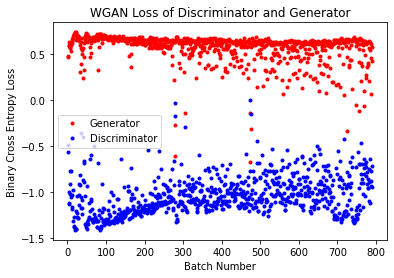

In [9]:
# Plot the loss of the generator and the descriminator
# plot predictions for arcsinh(x) and compate to ground truth
plt.plot(count_list, gen_loss_list, 'r.', label='Generator')
plt.plot(count_list, disc_loss_list, 'b.', label='Discriminator')
plt.title("WGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Binary Cross Entropy Loss")
plt.legend(loc = "best")
plt.show()